# NSynth

__Neural Audio Synthesis of Musical Notes with WaveNet Autoencoders, ICML 2017__

This colab notebook has everything you need to upload your own sounds and use NSynth models to reconstruct and interpolate between them.

# Setup Environment

First, we need to start download and select the pre-trained NSynth model to use.

In [ ]:
#@title Setup Environment
#@test {"output": "ignore"}


# Install magenta
print('Installing Magenta...\n')
!pip install -qU magenta
print('Installing ffmpeg...\n')
!echo "Yes" | apt-get install ffmpeg > /dev/null


print('Downloading Pretrained Models...\n')
# Copy checkpoints from google cloud
# Copying 1GB, takes a minute
print('Getting Instruments Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar /content/
print('Getting Voices Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz /content/
!cd /content/
!tar -xvf wavenet-ckpt.tar > /dev/null
!tar -xvf wavenet-voice-ckpt.tar.gz > /dev/null


print('Importing Modules...\n')
# Load modules and helper functions
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

from google.colab import files
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from note_seq.notebook_utils import colab_play as play

def upload(sample_length, sr):
  '''Upload a .wav file.'''
  filemap = files.upload()
  file_list, audio_list = [], []
  for key, value in filemap.items():
    fname = os.path.join('/content/', key)
    with open(fname, 'wb') as f:
      f.write(value)
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    file_list.append(fname)
    audio_list.append(audio)
  return file_list, audio_list

download = files.download

get_name = lambda f: os.path.splitext(os.path.basename(f))[0]

print('Sucess!! Environment is now setup.')


Installing Magenta...

Installing ffmpeg...


Getting Instruments Model...

Getting Voices Model...

Importing Modules...



/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Sucess!! Environment is now setup.


We have two pretrained models to choose from. One trained on the individual instrument notes of the [NSynth Dataset](https://magenta.tensorflow.org/datasets/nsynth) ("Instruments"), and another trained on a variety of voices in the wild for an art project ("Voices", mixture of singing and speaking). The Instruments model was trained on a larger quantity of data, so tends to generalize a bit better. Neither reconstructs audio perfectly, but both add their own unique character to sounds. Explore them both and see what you like!

In [ ]:
#@title Choose a Model { vertical-output: true, run: "auto" }
Model = "Instruments" #@param ["Instruments", "Voices"] {type:"string"}
ckpts = {'Instruments': '/content/wavenet-ckpt/model.ckpt-200000',
         'Voices': '/content/wavenet-voice-ckpt/model.ckpt-200000'}

ckpt_path = ckpts[Model]
print('Using model pretrained on %s.' % Model)

Using model pretrained on Instruments.


# Load Sound Files

Now it's time for you to load your own sound files for processing. You can use either `.wav` files or `.mp3` files, but in either case they will be converted to `.wav`. All files will be downsampled to 16kHz and cropped / silence padded to `Length` seconds as the input and output to the algorithm.

Keep in mind, with the cloud GPU synthesis takes around 4 minutes / 1 second of length.

In [ ]:
#@title Set Sound Length (in Seconds) { vertical-output: true, run: "auto" }
Length = 2.0 #@param {type:"number"}
SR = 16000
SAMPLE_LENGTH = int(SR * Length)

Put all your sound files into a single folder and maker sure to select all the files you want to reconstruct / interpolate between. **(Ctrl/Cmd/Shift Click)**

In [ ]:
#@title Upload sound files (.wav, .mp3)

try:
  file_list, audio_list = upload(sample_length=SAMPLE_LENGTH, sr=SR)
  names = [get_name(f) for f in file_list]
  # Pad and peak normalize
  for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) < SAMPLE_LENGTH:
      padding = SAMPLE_LENGTH - len(audio_list[i])
      audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')

  audio_list = np.array(audio_list)
except Exception as e:
  print('Upload Cancelled')
  print(e)

Saving Vibraphone.shortsustain.ff.C4.stereo.aif to Vibraphone.shortsustain.ff.C4.stereo (1).aif
Saving Guitar.pp.sulA.C4E4.stereo.aif to Guitar.pp.sulA.C4E4.stereo (3).aif
Saving Piano.ff.C4.aiff to Piano.ff.C4 (3).aiff
Saving clave1.ff.stereo.aif to clave1.ff.stereo (1).aif
Saving thaigong.ff.C5.stereo.aif to thaigong.ff.C5.stereo (2).aif
Saving 13crash.stick.normal.ff.stereo.aif to 13crash.stick.normal.ff.stereo.aif
Saving bells.brass.ff.C5.stereo.aif to bells.brass.ff.C5.stereo (1).aif
Saving Xylophone.hardrubber.roll.ff.C5.stereo.aif to Xylophone.hardrubber.roll.ff.C5.stereo.aif
Saving Bass.arco.ff.sulD.C4.stereo.aif to Bass.arco.ff.sulD.C4.stereo (1).aif
Saving Marimba.yarn.ff.C4.stereo.aif to Marimba.yarn.ff.C4.stereo (2).aif
Saving Bass.pizz.ff.sulD.C4.stereo.aif to Bass.pizz.ff.sulD.C4.stereo (1).aif
Saving Cello.arco.ff.sulC.C4.stereo.aif to Cello.arco.ff.sulC.C4.stereo (1).aif
Saving Viola.arco.ff.sulC.C4.stereo.aif to Viola.arco.ff.sulC.C4.stereo (1).aif
Saving Violin.pizz.f

# Encode

Next we need to encode the audio. We will also create interpolations (the midpoints between each encoding) from which to re-synthesize audio.

In [ ]:
#@title Generate Encodings
audio = np.array(audio_list)
z = fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
print('Encoded %d files' % z.shape[0])


# Start with reconstructions
z_list = [z_ for z_ in z]
name_list = ['recon_' + name_ for name_ in names]

# Add all the mean interpolations
n = len(names)
for i in range(n - 1):
  for j in range(i + 1, n):
    new_z = (z[i] + z[j]) / 2.0
    new_name = 'interp_' + names[i] + '_X_'+ names[j]
    z_list.append(new_z)
    name_list.append(new_name)

print("%d total: %d reconstructions and %d interpolations" % (len(name_list), n, len(name_list) - n))

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
Encoded 21 files
231 total: 21 reconstructions and 210 interpolations


We can take a look at the encoding of our audio files. They are compressed representations of the audio.

Guitar.pp.sulA.C4E4.stereo


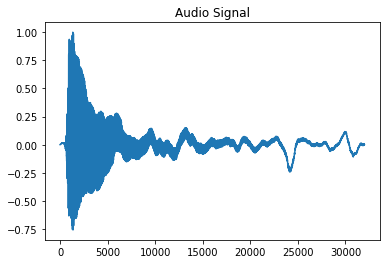

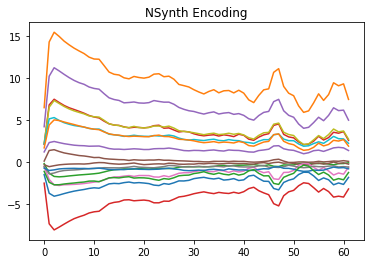

In [ ]:
#@title Visualize Audio and Encoding { vertical-output: true, run: "auto" }
SoundFile = 1 #@param {type:"slider", min:0, max:10, step:1}
file_number = SoundFile

try:
  print(names[file_number])
  play(audio_list[file_number], sample_rate=SR)
  # fig, axs = plt.subplots(2, 1, figsize=(12, 10))
  plt.figure()
  plt.plot(audio_list[file_number])
  plt.title('Audio Signal')

  plt.figure()
  plt.plot(z_list[file_number])
  plt.title('NSynth Encoding')
except Exception as e:
  print(e)

# Synthesize

Next, we synthesize the audio.

In [ ]:
#@title Synthesize Interpolations
print('Total Iterations to Complete: %d\n' % SAMPLE_LENGTH)

encodings = np.array(z_list)
save_paths = ['/content/' + name + '.wav' for name in name_list]
fastgen.synthesize(encodings,
                   save_paths=save_paths,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

Total Iterations to Complete: 32000

INFO:tensorflow:Restoring parameters from /content/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: /content/recon_Vibraphone.shortsustain.ff.C4.stereo.wav
INFO:tensorflow:Saving: /content/recon_Guitar.pp.sulA.C4E4.stereo.wav
INFO:tensorflow:Saving: /content/recon_Piano.ff.C4.wav
INFO:tensorflow:Saving: /content/recon_clave1.ff.stereo.wav
INFO:tensorflow:Saving: /content/recon_thaigong.ff.C5.stereo.wav
INFO:tensorflow:Saving: /content/recon_13crash.stick.normal.ff.stereo.wav
INFO:tensorflow:Saving: /content/recon_bells.brass.ff.C5.stereo.wav
INFO:tensorflow:Saving: /content/recon_Xylophone.hardrubber.roll.ff.C5.stereo.wav
INFO:tensorflow:Saving: /content/recon_Bass.arco.ff.sulD.C4.stereo.wav
INFO:tensorflow:Saving: /content/recon_Marimba.yarn.ff.C4.stereo.wav
INFO:tensorflow:Saving: /content/recon_Bass.pizz.ff.sulD.C4.stereo.wav
INFO:tensorflow:Saving: /content/recon_Cello.arco.ff.sulC.C4.stereo.wav
INFO:tensorflow:Sa

In [ ]:
#@title Download Interpolations
for fname in save_paths:
  print('Downloading: %s' % fname.split('/')[-1])
  download(fname)

Downloading: recon_Vibraphone.shortsustain.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Guitar.pp.sulA.C4E4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Piano.ff.C4.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_clave1.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_thaigong.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_13crash.stick.normal.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: recon_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Guitar.pp.sulA.C4E4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Piano.ff.C4.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_clave1.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_thaigong.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_13crash.stick.normal.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Vibraphone.shortsustain.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Piano.ff.C4.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_clave1.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_thaigong.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_13crash.stick.normal.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Guitar.pp.sulA.C4E4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_clave1.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_thaigong.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_13crash.stick.normal.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Piano.ff.C4_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_thaigong.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_13crash.stick.normal.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_clave1.ff.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_13crash.stick.normal.ff.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_thaigong.ff.C5.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_bells.brass.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_13crash.stick.normal.ff.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Xylophone.hardrubber.roll.ff.C5.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_bells.brass.ff.C5.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Bass.arco.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Xylophone.hardrubber.roll.ff.C5.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Marimba.yarn.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.arco.ff.sulD.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_Bass.pizz.ff.sulD.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Marimba.yarn.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_Cello.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Bass.pizz.ff.sulD.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_Viola.arco.ff.sulC.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Cello.arco.ff.sulC.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_Violin.pizz.ff.sulG.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Viola.arco.ff.sulC.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_Tuba.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Violin.pizz.ff.sulG.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Tuba.ff.C4.stereo_X_TenorTrombone.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Tuba.ff.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Tuba.ff.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Tuba.ff.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Tuba.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_Tuba.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_TenorTrombone.ff.C4.stereo_X_SopSax.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_TenorTrombone.ff.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_TenorTrombone.ff.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_TenorTrombone.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_TenorTrombone.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_SopSax.nonvib.ff.C4.stereo_X_EbClarinet.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_SopSax.nonvib.ff.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_SopSax.nonvib.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_SopSax.nonvib.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_EbClarinet.ff.C4.stereo_X_BassFlute.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_EbClarinet.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_EbClarinet.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_BassFlute.ff.C4.stereo_X_AltoFlute.vib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_BassFlute.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: interp_AltoFlute.vib.ff.C4.stereo_X_Flute.nonvib.ff.C4.stereo.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for fname in save_paths:
            ziph.write(fname)

zipf = zipfile.ZipFile('Sounds.zip', 'w')
zipdir('/content/', zipf)
zipf.close()

download('/content/Sounds.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Listen to the outputs

print("Originals:\n")
for fname in file_list:
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

for i, fname in enumerate(save_paths):
  if i == 0:
    print("Reconstructions:\n")
  if i == len(file_list):
    print("Interpolations:\n")
  synth_audio = utils.load_audio(fname,
                                 sample_length=SAMPLE_LENGTH,
                                 sr=SR)
  print(get_name(fname))
  play(synth_audio, sample_rate=SR)

Originals:

BassFlute.ff.C4.stereo


Marimba.yarn.ff.C4.stereo


Reconstructions:

recon_BassFlute.ff.C4.stereo


recon_Marimba.yarn.ff.C4.stereo


Interpolations:

interp_BassFlute.ff.C4.stereo_X_Marimba.yarn.ff.C4.stereo
